In [5]:
import fiftyone as fo
import pandas as pd
import os
import glob
from tqdm import tqdm
import timm
import torch
import numpy as np
import cv2
import pickle


ds_root = os.path.join(os.environ["DATASET_ROOT"], "bcd2022")
image_root = os.path.join(ds_root, "max_min_1024")
image_root

'/media/node_ale/DATA/datasets/bcd2022/max_min_1024'

In [6]:
fo.list_datasets()

['bcd2022_512']

In [7]:
try:
    dataset = fo.Dataset("bcd2022_512", overwrite=True)
except ValueError as e:
    dataset = fo.load_dataset("bcd2022_512")
    # overwrite=True force the overvwrite
    print(e)

In [8]:
dataset

Name:        bcd2022_512
Media type:  None
Num samples: 0
Persistent:  False
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)

In [9]:
df = pd.read_csv(os.path.join(ds_root, "train.csv"))
df.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [10]:
df["laterality"] = df["laterality"].astype(str)
df["view"] = df["view"].astype(str)
df["density"] = df["density"].astype(str)
df["machine_id"] = df["machine_id"].astype(str)

In [11]:
for index, row in tqdm(df.iterrows()):
    filename = f"{row.patient_id}_{row.image_id}.png"
    sample_path = os.path.join(image_root, filename)
    sample = fo.Sample(filepath=sample_path)
    sample["l_site_id"] = row.site_id
    sample["l_laterality"] = row.laterality
    sample["l_view"] = row["view"]
    sample["l_age"] = row.age
    sample["l_cancer"] = row.cancer
    sample["l_biopsy"] = row.biopsy
    sample["l_invasive"] = row.invasive
    sample["l_BIRADS"] = row.BIRADS
    sample["l_implant"] = row.implant
    sample["l_density"] = row.density
    sample["l_machine_id"] = str(row.machine_id)
    sample["l_difficult_negative_case"] = row.difficult_negative_case
    dataset.add_sample(sample)


54706it [00:57, 953.82it/s] 


In [23]:

#with open("samples.pkl", "wb") as fp:
#    pickle.dump(sample, fp)

# Embeddings

In [ ]:
# Do Only the first time (Save as emb.npy)
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

device = "cuda:0"

class DatasetInf:
    def __init__(self, path):
        self.path = path
    def __len__(self):
        return len(self.path)
    def __getitem__(self, index):
        img = cv2.imread(self.path[index], 0)
        img = A.Compose([A.Resize(width=224, height=224), A.ToFloat(), ToTensorV2()])(image=img)["image"]
        return img
paths = [x for x in dataset.values("filepath") ]
d = DatasetInf(paths)
loader = torch.utils.data.DataLoader(d, num_workers=8, batch_size=64)

model = timm.create_model("resnet50", in_chans=1, pretrained=True, num_classes=0)
model.eval()
model.to(device)
emb = []
for k, img in enumerate(tqdm(loader)):
    with torch.no_grad():
        output = model(img.to(device))
    emb += [output.cpu().numpy()]

emb = np.vstack(emb)
np.save("emb", emb)
print(emb.shape)

In [ ]:
emb.shape

In [12]:
import fiftyone.brain as fob
emb = np.load("emb.npy")

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=emb,
    num_dims=2,
    method="umap",
    brain_key="mnist_test",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(random_state=51, verbose=True)
Fri Dec 16 19:25:00 2022 Construct fuzzy simplicial set
Fri Dec 16 19:25:00 2022 Finding Nearest Neighbors
Fri Dec 16 19:25:00 2022 Building RP forest with 17 trees
Fri Dec 16 19:25:03 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Fri Dec 16 19:25:16 2022 Finished Nearest Neighbor Search
Fri Dec 16 19:25:18 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Dec 16 19:25:46 2022 Finished embedding


# Launch Session

In [14]:
fo.config.default_app_port

5151

In [27]:
session = fo.launch_app(dataset)

plot = results.visualize(labels="l_cancer")
plot.show(width=720)

session.plots.attach(plot)

FigureWidget({
    'data': [{'customdata': array(['639cb7ab411975f59c5a0ac4', '639cb7ab411975f59c5a0ac5',
    …


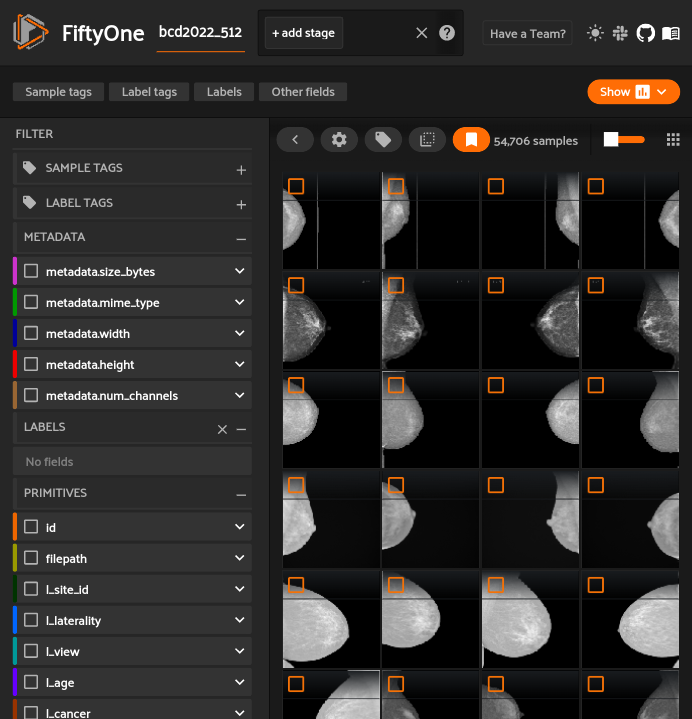